# Correlation & Confounding Analysis (Neo4j → Parquet → Metrics)

Uses explicit Phase-1 and Phase-2 features

Uses parquet as intermediary storage for speed and RAM savings.

Safe defaults for our VM:
- `PAGE_SIZE = 50_000`
- `SAMPLE_RATE = 1.00` (percentage of data)
- `N_WORKERS = 1`


## 1) Initial setup

In [24]:
# If needed once per kernel:
# %pip install seaborn -q

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, glob
from datetime import datetime, timezone, timedelta
import pandas as pd
from neo4j import GraphDatabase

# ======================== CONFIG (FINAL) ========================
NEO4J_URI      = "bolt://192.168.0.5:7687"
NEO4J_USER     = "neo4j"
NEO4J_PASSWORD = "PotatoDTND12!"

START_EPOCH = 1743476400  # 2025-04-01 00:00:00 UTC
END_EPOCH   = 1746068400  # 2025-05-01 00:00:00 UTC

TX_LABEL       = "Transaction"
TIMESTAMP_PROP = "timestamp"
JOIN_KEY_CANDIDATES = ["tx_hash","hash","txid","id","uuid"]

# Explicit feature list
PHASE1_FEATURE_LIST = ["from_pagerank","to_pagerank","from_centrality","to_centrality"]
PHASE2_FEATURE_LIST = ["funneling_score_v2","funneling_multiple_senders_v2","smurfing_score_v2","smurfing_small_tx_count_v2"]

PAGE_SIZE    = 50_000
SAMPLE_RATE  = 1.00
N_WORKERS    = 1

OUT_DIR_PARTS = "/root/neo4j_apr2025_parts" 
OUT_FINAL     = "/root/apr2025_phase_features.parquet"
OUT_ANALYSIS_DIR = "/root/corr_outputs_neo4j"

ANALYSIS_SAMPLE_N = 400_000
# ================================================================


## 2) Extract April 2025 transactions to Parquet (paged, daily parts)

In [25]:
os.makedirs(OUT_DIR_PARTS, exist_ok=True)
os.makedirs(OUT_ANALYSIS_DIR, exist_ok=True)

Q_PAGE_EXPL = f"""
WITH $feat AS feat, $keep AS keep
MATCH (tx:{TX_LABEL})
WHERE tx.{TIMESTAMP_PROP} >= $startEpoch AND tx.{TIMESTAMP_PROP} < $endEpoch
  AND ( $sampleRate >= 1.0 OR rand() < $sampleRate )
WITH tx, [k IN keys(tx) WHERE k IN feat OR k IN keep] AS ks
RETURN ks AS keys, [k IN ks | tx[k]] AS vals
ORDER BY tx.{TIMESTAMP_PROP}, elementId(tx)
SKIP $skip LIMIT $limit
"""

def daily_windows_utc(start_epoch, end_epoch):
    start = datetime.fromtimestamp(int(start_epoch), tz=timezone.utc)
    end   = datetime.fromtimestamp(int(end_epoch), tz=timezone.utc)
    cur = start; out = []
    while cur < end:
        nxt = min(cur + timedelta(days=1), end)
        out.append((int(cur.timestamp()), int(nxt.timestamp()), cur.strftime("%Y-%m-%d")))
        cur = nxt
    return out

def fetch_one_day(day_tuple):
    start_epoch, end_epoch, day_tag = day_tuple
    # cleanup old parts
    for old in glob.glob(os.path.join(OUT_DIR_PARTS, f"apr2025_{day_tag}_part*.parquet")):
        try: os.remove(old)
        except: pass

    driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))
    written, part_idx = 0, 0
    with driver.session(fetch_size=PAGE_SIZE) as session:
        skip = 0
        while True:
            params = {
                "startEpoch": int(start_epoch),
                "endEpoch": int(end_epoch),
                "skip": int(skip),
                "limit": int(PAGE_SIZE),
                "sampleRate": float(SAMPLE_RATE),
                "keep": [TIMESTAMP_PROP] + JOIN_KEY_CANDIDATES[:1],
                "feat": PHASE1_FEATURE_LIST + PHASE2_FEATURE_LIST,
            }
            rows = []
            for rec in session.run(Q_PAGE_EXPL, **params):
                ks, vs = rec["keys"], rec["vals"]
                rows.append(dict(zip(ks, vs)))
            if not rows: break

            df = pd.DataFrame(rows)
            if df.empty: break
            for c in df.select_dtypes(include="float").columns:
                df[c] = df[c].astype("float32")

            part_path = os.path.join(OUT_DIR_PARTS, f"apr2025_{day_tag}_part{part_idx:04d}.parquet")
            df.to_parquet(part_path, engine="pyarrow", index=False, compression="snappy")
            part_idx += 1
            written += len(df)
            skip += PAGE_SIZE
    driver.close()
    return day_tag, written, part_idx

windows = daily_windows_utc(START_EPOCH, END_EPOCH)
results = []
for w in windows:
    tag, n, n_parts = fetch_one_day(w)
    print(f"{tag} → {n:,} rows → {n_parts} parts")
    results.append((tag, n, n_parts))


2025-04-01 → 62,758 rows → 2 parts
2025-04-02 → 95,223 rows → 2 parts
2025-04-03 → 133,875 rows → 3 parts
2025-04-04 → 112,713 rows → 3 parts
2025-04-05 → 93,828 rows → 2 parts
2025-04-06 → 112,378 rows → 3 parts
2025-04-07 → 123,821 rows → 3 parts
2025-04-08 → 160,937 rows → 4 parts
2025-04-09 → 99,368 rows → 2 parts
2025-04-10 → 63,294 rows → 2 parts
2025-04-11 → 107,651 rows → 3 parts
2025-04-12 → 104,244 rows → 3 parts
2025-04-13 → 112,547 rows → 3 parts
2025-04-14 → 140,870 rows → 3 parts
2025-04-15 → 144,036 rows → 3 parts
2025-04-16 → 138,260 rows → 3 parts
2025-04-17 → 129,595 rows → 3 parts
2025-04-18 → 110,942 rows → 3 parts
2025-04-19 → 93,273 rows → 2 parts
2025-04-20 → 94,382 rows → 2 parts
2025-04-21 → 132,540 rows → 3 parts
2025-04-22 → 150,711 rows → 4 parts
2025-04-23 → 153,398 rows → 4 parts
2025-04-24 → 158,165 rows → 4 parts
2025-04-25 → 161,130 rows → 4 parts
2025-04-26 → 117,415 rows → 3 parts
2025-04-27 → 110,009 rows → 3 parts
2025-04-28 → 153,979 rows → 4 parts

## 3) Consolidate parts into single Parquet file and display sample

In [28]:

import pandas as pd, glob, os
if os.path.exists(OUT_FINAL): os.remove(OUT_FINAL)
part_paths = sorted(glob.glob(os.path.join(OUT_DIR_PARTS, "apr2025_*_part*.parquet")))
if not part_paths: raise RuntimeError("No part files found — check extraction output")

CHUNK = 50
dfs = []
for i in range(0, len(part_paths), CHUNK):
    group = part_paths[i:i+CHUNK]
    dfs.append(pd.concat([pd.read_parquet(p) for p in group], ignore_index=True))
df_all = pd.concat(dfs, ignore_index=True)
df_all.to_parquet(OUT_FINAL, engine="pyarrow", index=False, compression="snappy")
print("Final dataset:", OUT_FINAL, df_all.shape)
df_all.head(3)

Final dataset: /root/apr2025_phase_features.parquet (3675439, 9)


,smurfing_small_tx_count_v2,funneling_score_v2,smurfing_score_v2,funneling_multiple_senders_v2,to_centrality,to_pagerank,from_centrality,from_pagerank,timestamp
0,160,0.000302,0.019235,40,0.001836,0.000314,0.000303,0.000031,1743476411
1,0,0.005925,0.000000,944,0.047747,0.018948,0.000009,0.000003,1743476411
2,1,0.083959,0.000526,2120,0.080518,0.034391,0.000009,0.000004,1743476411


## 4) Display cross-correlation

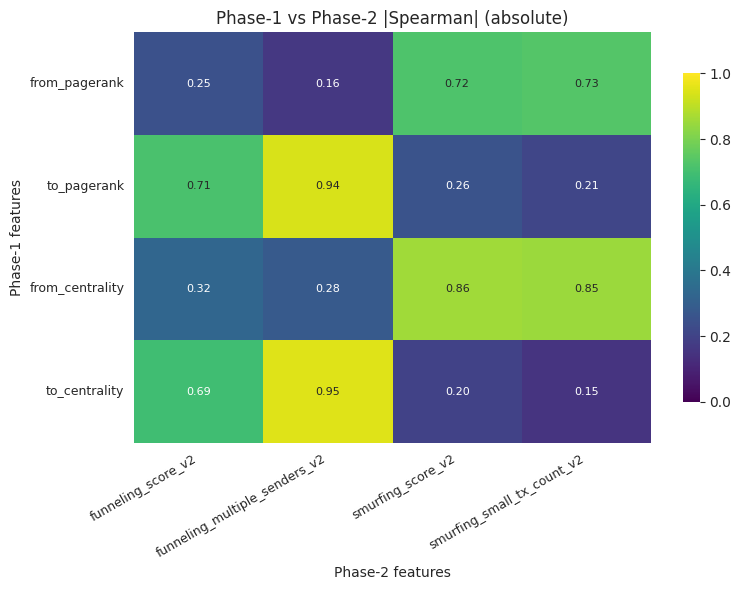


Top Phase-1 ↔ Phase-2 correlations (|Spearman| ≥ 0.7):


,level_0,level_1,abs_spearman
13,to_centrality,funneling_multiple_senders_v2,0.952615
5,to_pagerank,funneling_multiple_senders_v2,0.937582
10,from_centrality,smurfing_score_v2,0.855876
11,from_centrality,smurfing_small_tx_count_v2,0.849531
3,from_pagerank,smurfing_small_tx_count_v2,0.732782
2,from_pagerank,smurfing_score_v2,0.720234
4,to_pagerank,funneling_score_v2,0.711097


In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1) Validate columns and subset -----------------------------------------
def _valid_numeric(cols, df):
    return [c for c in cols if c in df.columns and pd.api.types.is_numeric_dtype(df[c])]

p1_cols = _valid_numeric(PHASE1_FEATURE_LIST, df_all)
p2_cols = _valid_numeric(PHASE2_FEATURE_LIST, df_all)

df_p1 = df_all[p1_cols].copy()
df_p2 = df_all[p2_cols].copy()

# --- 2) Cross-phase absolute Spearman correlation (rows=P1, cols=P2) --------
cross = pd.DataFrame(index=p1_cols, columns=p2_cols, dtype=float)
for c1 in p1_cols:
    for c2 in p2_cols:
        cross.loc[c1, c2] = df_p1[c1].corr(df_p2[c2], method='spearman')
corr_cross = cross.abs()

# --- 3) Plot: only the cross heatmap with label overlap fixes ----------------
# Dynamic height: scale by number of Phase-1 features
height = max(6, 0.6 * len(p1_cols))     # tweak 0.6 if you want tighter/looser
width  = max(8, 0.5 * len(p2_cols) + 6) # widen a bit as Phase-2 count grows

sns.set_style("white")
fig, ax = plt.subplots(figsize=(width, height))

hm = sns.heatmap(
    corr_cross, cmap="viridis", vmin=0, vmax=1,
    annot=True, fmt=".2f", annot_kws={"size":8},
    cbar_kws={"shrink": .8}, ax=ax
)

# Titles and axes labels
ax.set_title("Phase-1 vs Phase-2 |Spearman| (absolute)")
ax.set_xlabel("Phase-2 features")
ax.set_ylabel("Phase-1 features")

# Tick label formatting to avoid overlap
ax.tick_params(axis='y', labelsize=9)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, va='center')

ax.tick_params(axis='x', labelsize=9)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

# Extra left margin for long Phase-1 labels
plt.subplots_adjust(left=0.30)  # increase to 0.35–0.40 if still tight

plt.tight_layout()
plt.show()

# ---- Redundancy report (top cross-phase pairs) ------------------------------
thr = 0.70  # adjust threshold if needed
pairs = (corr_cross.stack()
         .rename("abs_spearman")
         .reset_index()
         .sort_values("abs_spearman", ascending=False))
top_pairs = pairs[pairs["abs_spearman"] >= thr]

print(f"\nTop Phase-1 ↔ Phase-2 correlations (|Spearman| ≥ {thr}):")
if top_pairs.empty:
    print("  None above threshold.")
else:
    display(top_pairs.head(20))  # or print(top_pairs.head(20).to_string(index=False))



## 5) Display other metrics, Mutual Information, Canonical Correlation Analysis, Predictability

In [4]:
import numpy as np, pandas as pd
from scipy.stats import wasserstein_distance
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.cross_decomposition import CCA
from sklearn.linear_model import RidgeCV
import os

os.makedirs(OUT_ANALYSIS_DIR, exist_ok=True)
ALL = pd.read_parquet(OUT_FINAL)
print("Loaded:", ALL.shape)

p1_cols = PHASE1_FEATURE_LIST
p2_cols = PHASE2_FEATURE_LIST
P1_all = ALL[p1_cols].astype("float32")
P2_all = ALL[p2_cols].astype("float32")

if ANALYSIS_SAMPLE_N and len(ALL) > ANALYSIS_SAMPLE_N:
    SAMP = ALL.sample(ANALYSIS_SAMPLE_N, random_state=42)
    P1 = SAMP[p1_cols].astype("float32"); P2 = SAMP[p2_cols].astype("float32")
    print(f"Using sample of {len(SAMP):,} rows for MI/CCA/predictability")
else:
    P1, P2 = P1_all, P2_all
    print("Using full data")

# Paired Pearson & Wasserstein
pearson_pairs, w1_pairs = {}, {}
for a, b in zip(p1_cols, p2_cols):
    x, y = ALL[a].to_numpy(), ALL[b].to_numpy()
    m = np.isfinite(x) & np.isfinite(y)
    if m.sum() < 10: pearson_pairs[a] = np.nan; w1_pairs[a] = np.nan; continue
    pearson_pairs[a] = np.corrcoef(x[m], y[m])[0,1]
    w1_pairs[a] = wasserstein_distance(x[m], y[m])
pd.Series(pearson_pairs).to_csv(f"{OUT_ANALYSIS_DIR}/paired_pearson.csv")
pd.Series(w1_pairs).to_csv(f"{OUT_ANALYSIS_DIR}/paired_w1.csv")

# MI matrices (within-phase)
def mi_matrix(X_df):
    Xs = StandardScaler().fit_transform(X_df.values)
    m = Xs.shape[1]; MI = np.zeros((m,m), dtype="float32")
    for j in range(m):
        y = Xs[:, j]
        for i in range(m):
            if i == j: MI[i,j] = 0.0; continue
            MI[i,j] = mutual_info_regression(Xs[:, [i]], y, n_neighbors=5, random_state=42)[0]
    MI = np.maximum(MI, MI.T)
    return pd.DataFrame(MI, index=X_df.columns, columns=X_df.columns)

MI_p1 = mi_matrix(P1); MI_p2 = mi_matrix(P2)
MI_p1.to_csv(f"{OUT_ANALYSIS_DIR}/p1_mi.csv")
MI_p2.to_csv(f"{OUT_ANALYSIS_DIR}/p2_mi.csv")

# Predictability (R^2)
def predictability_score(X_src_df, X_tgt_df):
    Xs = StandardScaler().fit_transform(X_src_df.values)
    Yt = X_tgt_df.values; reg = RidgeCV(alphas=np.logspace(-3,3,13))
    r2s = []
    for j in range(Yt.shape[1]):
        y = Yt[:, j]; m = np.isfinite(y)
        if m.sum() < 50: continue
        reg.fit(Xs[m], y[m]); r2s.append(reg.score(Xs[m], y[m]))
    return pd.Series(r2s, dtype="float32")

r2_p2_from_p1 = predictability_score(P1, P2)
r2_p1_from_p2 = predictability_score(P2, P1)
pd.DataFrame({
    "p2_from_p1_mean_r2":[float(r2_p2_from_p1.mean())],
    "p1_from_p2_mean_r2":[float(r2_p1_from_p2.mean())],
}).to_csv(f"{OUT_ANALYSIS_DIR}/predictability_summary.csv", index=False)

# CCA
def cca_corrs(X1_df, X2_df, n_comp=4):
    k = min(n_comp, X1_df.shape[1], X2_df.shape[1])
    X1s = StandardScaler().fit_transform(X1_df.values)
    X2s = StandardScaler().fit_transform(X2_df.values)
    cca = CCA(n_components=k, max_iter=2000)
    U, V = cca.fit_transform(X1s, X2s)
    cors = [np.corrcoef(U[:,i], V[:,i])[0,1] for i in range(k)]
    return pd.Series(cors, index=[f"c{i+1}" for i in range(k)], dtype="float32")

cca_vals = cca_corrs(P1, P2, n_comp=4)
cca_vals.to_csv(f"{OUT_ANALYSIS_DIR}/cca_corrs.csv")
print("Saved outputs to:", OUT_ANALYSIS_DIR)


Loaded: (918978, 9)
Using sample of 400,000 rows for MI/CCA/predictability
Saved outputs to: /root/corr_outputs_neo4j


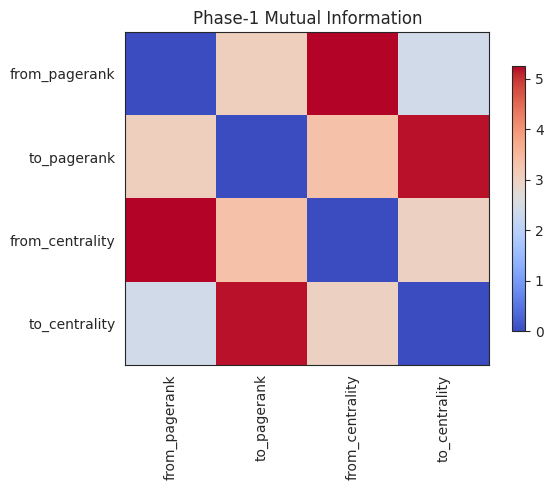

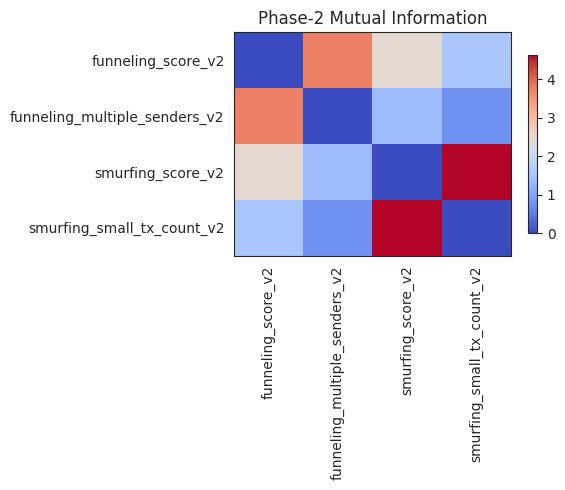

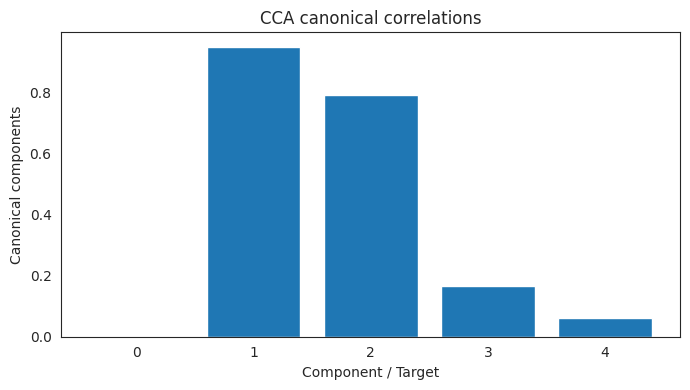

   p2_from_p1_mean_r2  p1_from_p2_mean_r2
0            0.411697            0.619173


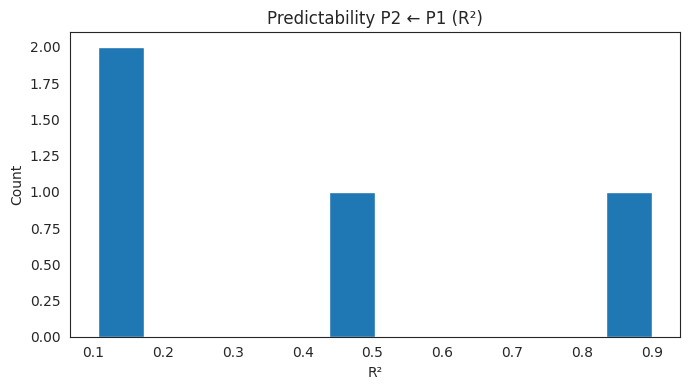

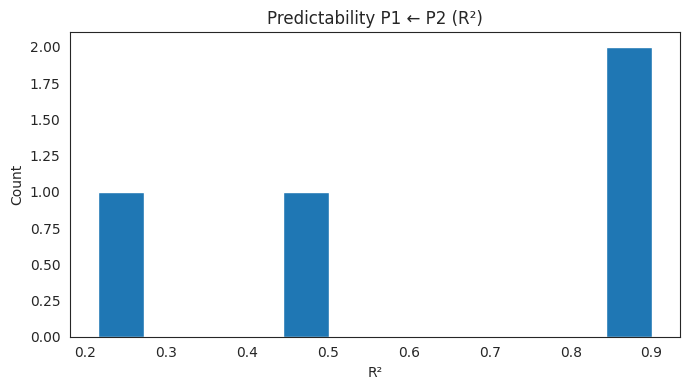

Top pairs by |Pearson|: [('to_pagerank', 'funneling_multiple_senders_v2', 0.9455734786398314), ('from_centrality', 'smurfing_score_v2', 0.5782644764511832), ('to_centrality', 'smurfing_small_tx_count_v2', -0.09866259913833798), ('from_pagerank', 'funneling_score_v2', -0.07019656807813496)]


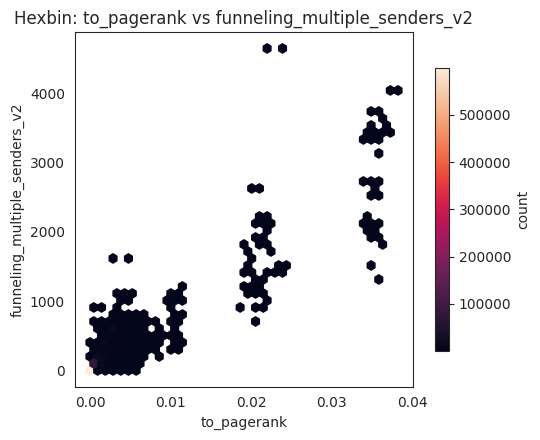

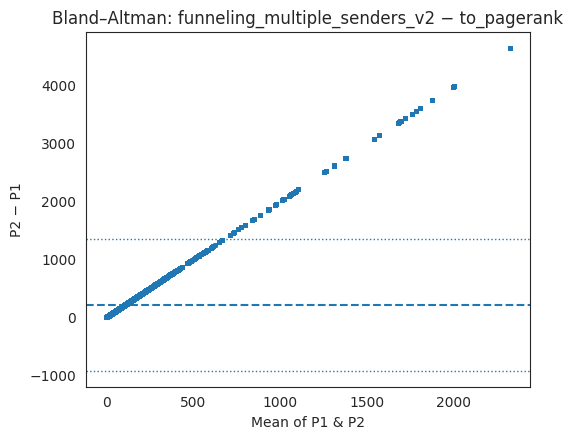

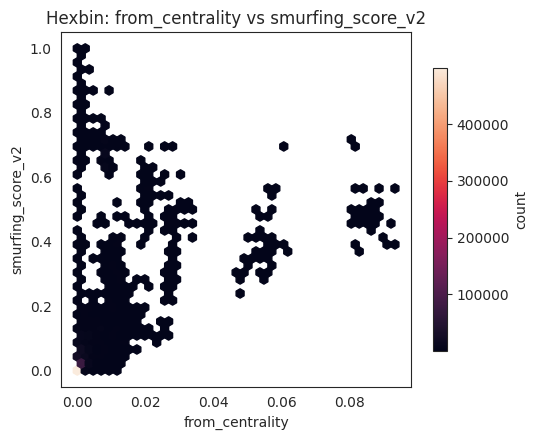

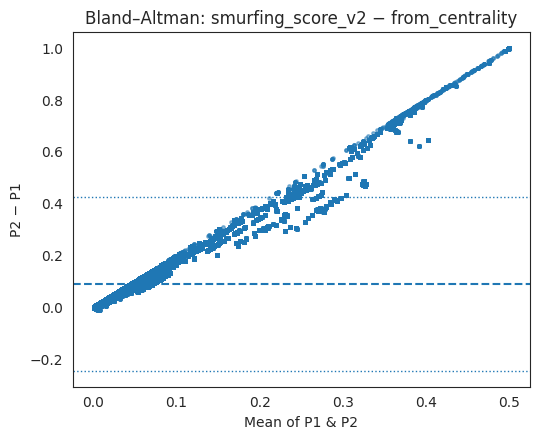

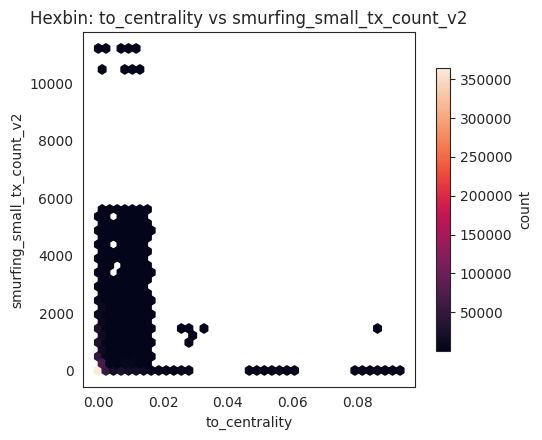

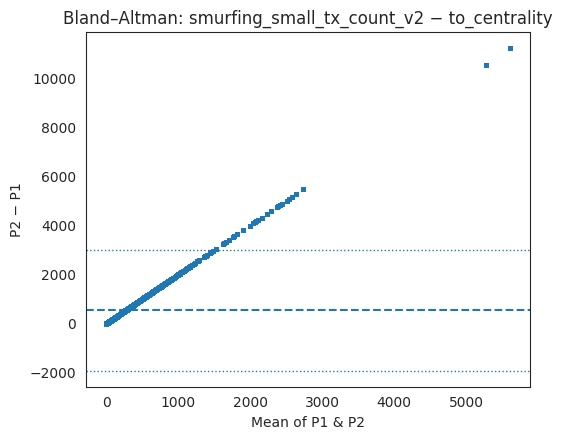

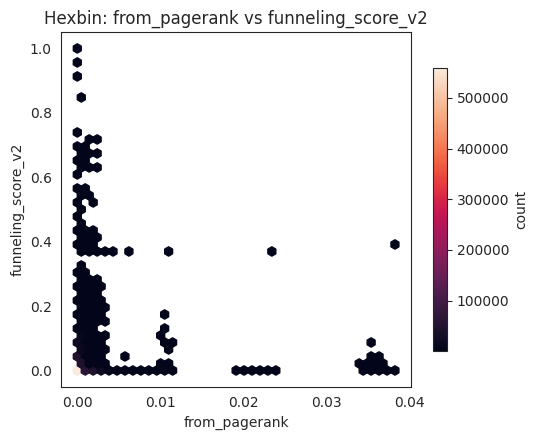

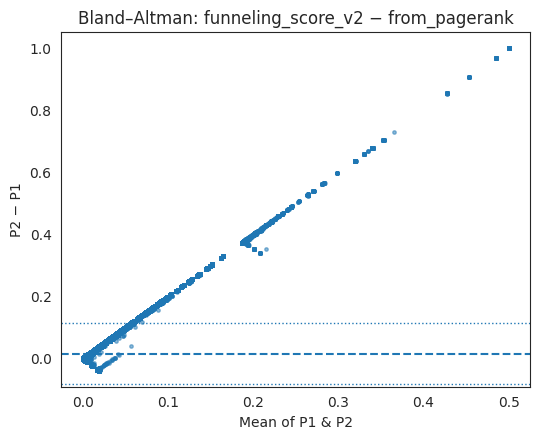

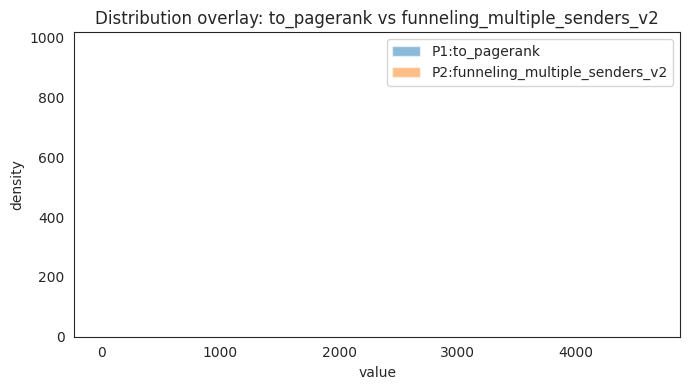

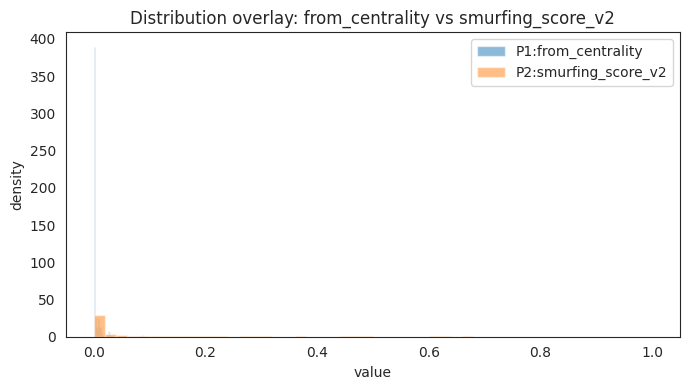

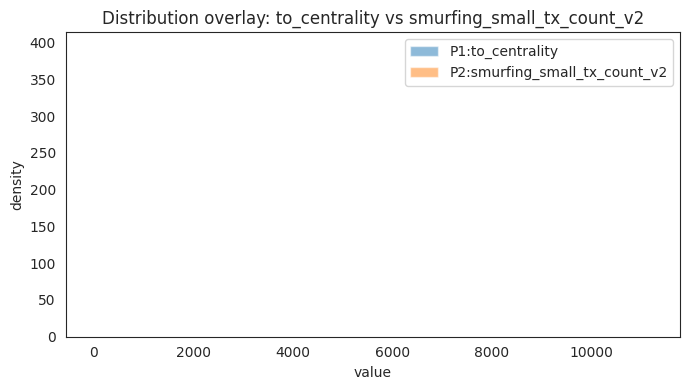

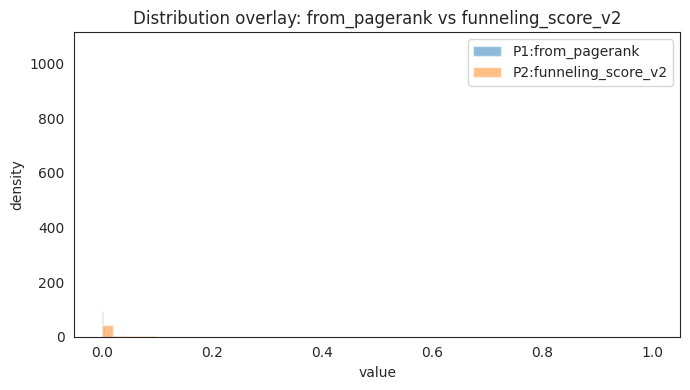

In [36]:
# %% [markdown]
# ## 3) Visualization — correlation, MI, cross-corr, CCA, predictability, pairwise diagnostics

# %%
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

os.makedirs(OUT_ANALYSIS_DIR, exist_ok=True)

# Utility: nice heatmap
def plot_heatmap(mat_df, title, outfile, vmin=None, vmax=None, cmap="coolwarm"):
    fig, ax = plt.subplots(figsize=(max(6, 0.5*len(mat_df.columns)), max(5, 0.5*len(mat_df.index))))
    im = ax.imshow(mat_df.values, aspect="auto", interpolation="nearest", cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.set_xticks(range(len(mat_df.columns)))
    ax.set_xticklabels(mat_df.columns, rotation=90)
    ax.set_yticks(range(len(mat_df.index)))
    ax.set_yticklabels(mat_df.index)
    cbar = fig.colorbar(im, ax=ax, shrink=0.8)
    fig.tight_layout()
    fig.savefig(outfile, dpi=180)
    plt.show()

# Utility: bar/hist wrapper
def plot_bar(vals, title, xlabel, outfile):
    fig, ax = plt.subplots(figsize=(7,4))
    ax.bar(range(len(vals)), vals)
    ax.set_title(title)
    ax.set_xlabel("Component / Target")
    ax.set_ylabel(xlabel)
    fig.tight_layout()
    fig.savefig(outfile, dpi=180)
    plt.show()

def plot_hist(vals, bins, title, xlabel, outfile):
    fig, ax = plt.subplots(figsize=(7,4))
    ax.hist(vals, bins=bins)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Count")
    fig.tight_layout()
    fig.savefig(outfile, dpi=180)
    plt.show()

# 3) Mutual information heatmaps (from MI_p1 / MI_p2 computed before)
try:
    MI_p1 = pd.read_csv(f"{OUT_ANALYSIS_DIR}/p1_mi.csv", index_col=0)
    MI_p2 = pd.read_csv(f"{OUT_ANALYSIS_DIR}/p2_mi.csv", index_col=0)
except Exception:
    # If files aren’t present, recompute briefly on the sampled P1/P2
    from sklearn.preprocessing import StandardScaler
    from sklearn.feature_selection import mutual_info_regression
    def mi_matrix(X_df):
        Xs = StandardScaler().fit_transform(X_df.values)
        m = Xs.shape[1]
        MI = np.zeros((m,m), dtype="float32")
        for j in range(m):
            y = Xs[:, j]
            for i in range(m):
                if i == j: MI[i,j] = 0.0
                else: MI[i,j] = mutual_info_regression(Xs[:, [i]], y, n_neighbors=5, random_state=42)[0]
        MI = np.maximum(MI, MI.T)
        return pd.DataFrame(MI, index=X_df.columns, columns=X_df.columns)
    MI_p1 = mi_matrix(P1)
    MI_p2 = mi_matrix(P2)

plot_heatmap(MI_p1, "Phase-1 Mutual Information", f"{OUT_ANALYSIS_DIR}/p1_mi_heatmap.png", vmin=0)
plot_heatmap(MI_p2, "Phase-2 Mutual Information", f"{OUT_ANALYSIS_DIR}/p2_mi_heatmap.png", vmin=0)

# 4) CCA canonical correlations — bar plot
try:
    cca_vals = pd.read_csv(f"{OUT_ANALYSIS_DIR}/cca_corrs.csv", header=None, index_col=0).iloc[:,0]
except Exception:
    cca_vals = pd.Series([], dtype="float32")
if len(cca_vals) > 0:
    plot_bar(cca_vals.values, "CCA canonical correlations", "Canonical components", f"{OUT_ANALYSIS_DIR}/cca_bars.png")

# 5) Predictability — mean R^2 summary and distribution
try:
    pred_df = pd.read_csv(f"{OUT_ANALYSIS_DIR}/predictability_summary.csv")
    print(pred_df)
except Exception:
    pred_df = None

# Recompute per-target R^2 vectors for histograms if needed
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler

def predictability_r2_vec(X_src_df, X_tgt_df):
    Xs = StandardScaler().fit_transform(X_src_df.values)
    Yt = X_tgt_df.values
    reg = RidgeCV(alphas=np.logspace(-3,3,13))
    r2s = []
    for j in range(Yt.shape[1]):
        y = Yt[:, j]
        m = np.isfinite(y)
        if m.sum() < 50: continue
        reg.fit(Xs[m], y[m])
        r2s.append(reg.score(Xs[m], y[m]))
    return np.array(r2s, dtype=float)

r2_p2_from_p1_vec = predictability_r2_vec(P1, P2)
r2_p1_from_p2_vec = predictability_r2_vec(P2, P1)

plot_hist(r2_p2_from_p1_vec, bins=12, title="Predictability P2 ← P1 (R²)", xlabel="R²", outfile=f"{OUT_ANALYSIS_DIR}/r2_hist_p2_from_p1.png")
plot_hist(r2_p1_from_p2_vec, bins=12, title="Predictability P1 ← P2 (R²)", xlabel="R²", outfile=f"{OUT_ANALYSIS_DIR}/r2_hist_p1_from_p2.png")

# 6) Pairwise diagnostics for top-k correlated pairs (by absolute Pearson)
# Build paired list (assumes both lists same length paired in order)
pairs = list(zip(p1_cols, p2_cols))
# Compute Pearson using ALL to rank pairs
pair_scores = []
for a, b in pairs:
    x, y = ALL[a].to_numpy(), ALL[b].to_numpy()
    m = np.isfinite(x) & np.isfinite(y)
    r = np.corrcoef(x[m], y[m])[0,1] if m.sum() > 10 else np.nan
    pair_scores.append((a, b, r))
pair_scores = [t for t in pair_scores if np.isfinite(t[2])]
pair_scores.sort(key=lambda t: abs(t[2]), reverse=True)

TOPK = min(4, len(pair_scores))
print("Top pairs by |Pearson|:", pair_scores[:TOPK])

def plot_hexbin_and_bland_altman(x, y, name_a, name_b, out_prefix):
    # Hexbin scatter
    fig, ax = plt.subplots(figsize=(5.5,4.5))
    hb = ax.hexbin(x, y, gridsize=40, mincnt=1)
    ax.set_xlabel(name_a); ax.set_ylabel(name_b)
    ax.set_title(f"Hexbin: {name_a} vs {name_b}")
    fig.colorbar(hb, ax=ax, shrink=0.8, label="count")
    fig.tight_layout()
    fig.savefig(f"{OUT_ANALYSIS_DIR}/{out_prefix}_hexbin.png", dpi=180)
    plt.show()

    # Bland–Altman (difference vs mean)
    m = np.isfinite(x) & np.isfinite(y)
    xm, ym = x[m], y[m]
    mean = 0.5*(xm + ym)
    diff = ym - xm
    md = np.mean(diff); sd = np.std(diff)
    loA, hiA = md - 1.96*sd, md + 1.96*sd
    fig, ax = plt.subplots(figsize=(5.5,4.5))
    ax.scatter(mean, diff, s=6, alpha=0.5)
    ax.axhline(md, linestyle="--")
    ax.axhline(loA, linestyle=":", linewidth=1)
    ax.axhline(hiA, linestyle=":", linewidth=1)
    ax.set_xlabel("Mean of P1 & P2")
    ax.set_ylabel("P2 − P1")
    ax.set_title(f"Bland–Altman: {name_b} − {name_a}")
    fig.tight_layout()
    fig.savefig(f"{OUT_ANALYSIS_DIR}/{out_prefix}_bland_altman.png", dpi=180)
    plt.show()

# Plot top pairs
for a, b, r in pair_scores[:TOPK]:
    x = ALL[a].to_numpy(); y = ALL[b].to_numpy()
    tag = f"{a}_vs_{b}".replace("/", "_")
    plot_hexbin_and_bland_altman(x, y, a, b, tag)

# 7) Optional: distribution overlays for each pair (sampled to keep it light)
def plot_distribution_overlay(x, y, a, b, outprefix, sample_n=200000):
    rng = np.random.default_rng(42)
    idx_x = rng.choice(len(x), size=min(sample_n, len(x)), replace=False)
    xm = x[idx_x]; ym = y[idx_x]
    fig, ax = plt.subplots(figsize=(7,4))
    ax.hist(xm[np.isfinite(xm)], bins=50, alpha=0.5, density=True, label=f"P1:{a}")
    ax.hist(ym[np.isfinite(ym)], bins=50, alpha=0.5, density=True, label=f"P2:{b}")
    ax.set_title(f"Distribution overlay: {a} vs {b}")
    ax.set_xlabel("value"); ax.set_ylabel("density")
    ax.legend()
    fig.tight_layout()
    fig.savefig(f"{OUT_ANALYSIS_DIR}/{outprefix}_dist_overlay.png", dpi=180)
    plt.show()

for a, b, _ in pair_scores[:TOPK]:
    x = ALL[a].to_numpy(); y = ALL[b].to_numpy()
    tag = f"{a}_vs_{b}".replace("/", "_")
    plot_distribution_overlay(x, y, a, b, tag)
